In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 로드

In [119]:
df = pd.read_csv('..\\data\\Preprocessed_Bank_Customer_Churn_Prediction.csv')

In [120]:
df 

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,0,39,5,0.00,2,1,0,96270.64,0
9996,516,0,0,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,1,36,7,0.00,1,0,1,42085.58,1
9998,772,1,0,42,3,75075.31,2,1,0,92888.52,1


### 추가 전처리

#### 로그 변환

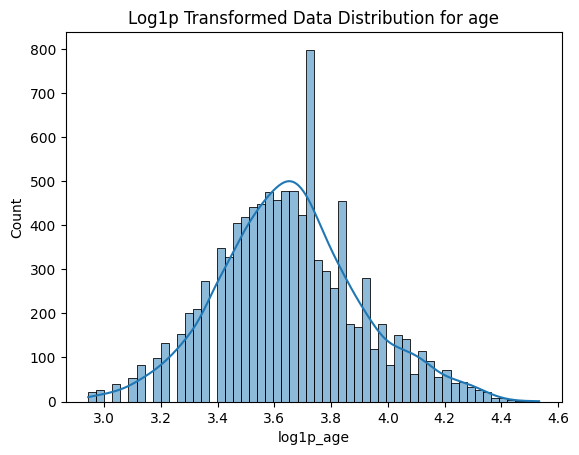

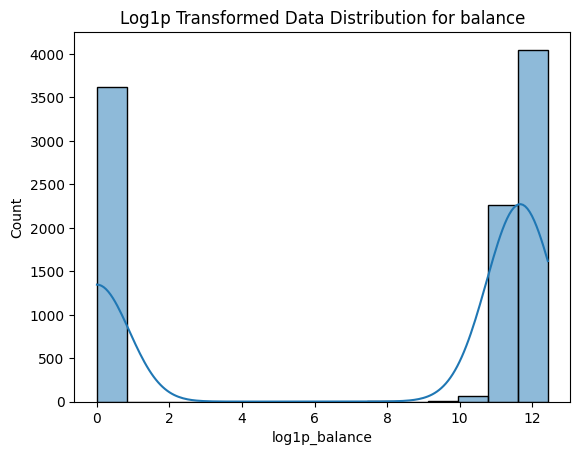

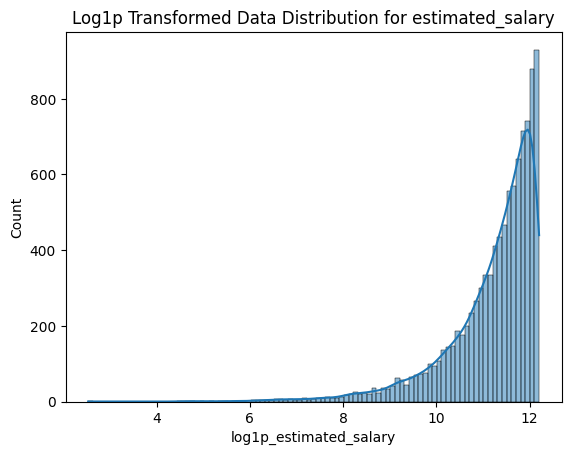

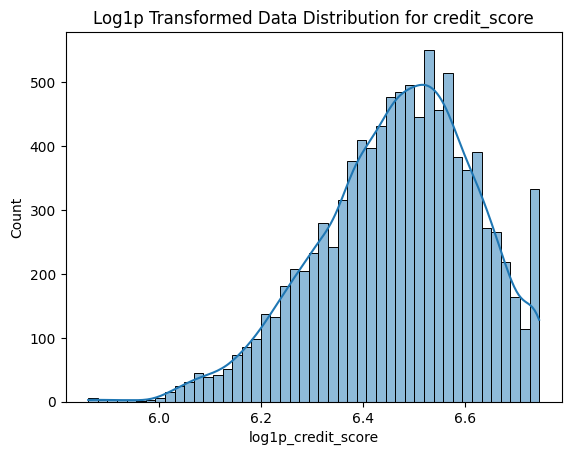

   credit_score  country  gender  age  tenure    balance  products_number  \
0           619        0       1   42       2       0.00                1   
1           608        2       1   41       1   83807.86                1   
2           502        0       1   42       8  159660.80                3   
3           699        0       1   39       1       0.00                2   
4           850        2       1   43       2  125510.82                1   

   credit_card  active_member  estimated_salary  churn  log1p_age  \
0            1              1         101348.88      1   3.761200   
1            0              1         112542.58      0   3.737670   
2            1              0         113931.57      1   3.761200   
3            0              0          93826.63      0   3.688879   
4            1              1          79084.10      0   3.784190   

   log1p_balance  log1p_estimated_salary  log1p_credit_score  
0       0.000000               11.526334            6.42971

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 예시 데이터 (실제 데이터프레임 df 사용)
# df = pd.read_csv("your_data.csv")

# 원본 데이터에서 왜도가 1보다 큰 컬럼 찾기
# skewness = df.skew()
# skewed_columns = skewness[skewness > 1].index
# print("왜도가 1보다 큰 컬럼들:", skewed_columns)  # 예시: age 컬럼 확인

# 'balance'와 'estimated_salary' 컬럼을 skewed_columns 리스트에 추가
skewed_columns = ['age', 'balance', 'estimated_salary', 'credit_score']  # 'balance'와 'estimated_salary' 추가

# log1p 변환 함수
def log1p_transform_columns(df, columns):
    for column in columns:
        df[f'log1p_{column}'] = np.log1p(df[column])  # np.log1p는 log(x+1)
    return df

# log1p 변환 수행
df = log1p_transform_columns(df, skewed_columns)

# log1p 변환 후 데이터 분포 시각화
for column in skewed_columns:
    sns.histplot(df[f'log1p_{column}'], kde=True)
    plt.title(f'Log1p Transformed Data Distribution for {column}')
    plt.show()

# 결과 출력
print(df.head())

# 변환된 'log1p_' 컬럼을 원래 컬럼에 대체하고, 불필요한 컬럼 제거
for column in skewed_columns:
    df[column] = df[f'log1p_{column}']
    df.drop([f'log1p_{column}'], axis=1, inplace=True)

# 최종 데이터 확인
print(df.head())


### 머신 러닝(로지스틱 회귀, k 최근접 이웃 모델)

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

### 평가 함수

In [123]:
def evaluation(model, X_test, y_test):
    # 예측 결과
    y_pred = model.predict(X_test)

    # 정확도
    accuracy = accuracy_score(y_test, y_pred)
    print(f"정확도: {accuracy * 100:.4f}%")

    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    print("혼동 행렬:\n", cm)

    # 정밀도: 정밀도는 예측한 클래스 1 중에서 실제로 클래스 1인 비율
    precision = precision_score(y_test, y_pred)
    print(f"정밀도: {precision:.4f}")

    # 재현율: 재현율은 실제 클래스 1 중에서 모델이 클래스 1로 예측한 비율
    recall = recall_score(y_test, y_pred)
    print(f"재현율: {recall:.4f}")

    # F1 점수: F1 점수는 정밀도와 재현율의 조화 평균, 두 지표의 균형을 맞추기 위한 지표
    f1 = f1_score(y_test, y_pred)
    print(f"F1 점수: {f1:.4f}")

    # ROC AUC
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # ROC 곡선 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


#### 데이터 분할

In [130]:
# 
label_name = 'churn'

X = df.drop(label_name, axis = 1)
y = df[label_name]  

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

##### 정규화

In [125]:
from sklearn.preprocessing import MinMaxScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = MinMaxScaler()

# 학습 데이터에 맞춰서 scaler 학습 (fit) 후, 학습 데이터 변환
X_train_normalized = scaler.fit_transform(X_train)

# 테스트 데이터에 학습된 scaler를 적용하여 변환
X_test_normalized = scaler.transform(X_test)

# 결과 확인
#print("학습 데이터 정규화:", X_train_normalized[:5])
#print("테스트 데이터 정규화:", X_test_normalized[:5])


##### 표준화

In [126]:
from sklearn.preprocessing import StandardScaler

# 표준화 (Standardization) - 평균 0, 표준편차 1로 변환
scaler = StandardScaler()

# 학습 데이터에 맞춰서 scaler 학습 (fit) 후, 학습 데이터 변환
X_train_scaled = scaler.fit_transform(X_train)

# 테스트 데이터에 학습된 scaler를 적용하여 변환
X_test_scaled = scaler.transform(X_test)

# 결과 확인
#print("학습 데이터 표준화:", X_train_scaled[:5])
#print("테스트 데이터 표준화:", X_test_scaled[:5])


* 로지스틱 회귀

정확도: 70.4333%
혼동 행렬:
 [[1663  726]
 [ 161  450]]
정밀도: 0.3827
재현율: 0.7365
F1 점수: 0.5036
AUC: 0.7922


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


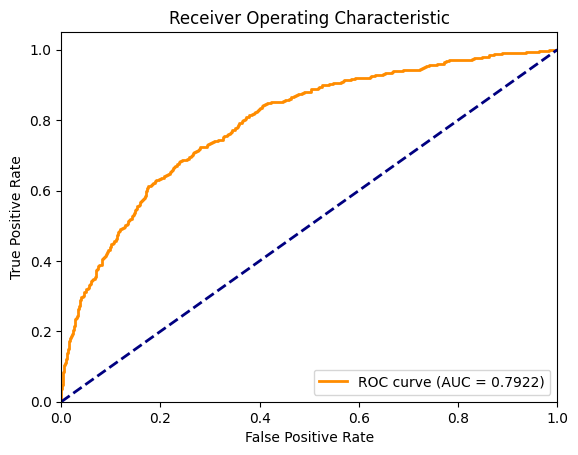

정확도: 79.6333%
혼동 행렬:
 [[2389    0]
 [ 611    0]]
정밀도: 0.0000
재현율: 0.0000
F1 점수: 0.0000
AUC: 0.7693


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


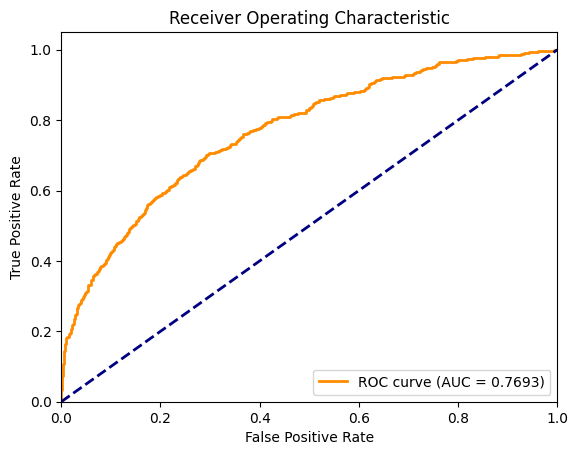

정확도: 79.6000%
혼동 행렬:
 [[2379   10]
 [ 602    9]]
정밀도: 0.4737
재현율: 0.0147
F1 점수: 0.0286
AUC: 0.7793


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


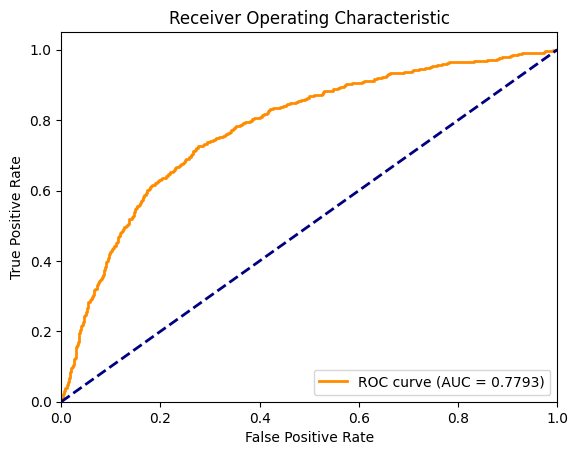

In [127]:
# 로지스틱 회귀 모델 학습
model = LogisticRegression(class_weight='balanced') # 가중치 조절을 했을 떄, 좀 더 성능이 높아지긴 하나, 크게 차이가 없음 
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_pred_n = model.predict(X_test_normalized)
y_pred_s = model.predict(X_test_scaled)

# 정확도 평가
evaluation(model, X_test, y_test)
evaluation(model, X_test_normalized, y_test)
evaluation(model, X_test_scaled, y_test)


* 표준화를 실시한 데이터를 넣은 모델이 가장 적합
    - 재현율이 가장 높다, F1 점수와 AUC가 뛰어나며, 고객 이탈을 예측하는 데 가장 효과적임. 
    - 이 모델은 이탈 고객을 놓치지 않고 잘 예측하므로 목적에 가장 잘 부합 

##### 추가적으로 실시할 수 있는 방법

* 불필요한 특성 제거: 유용한 정보가 없는 특성을 제거
* Regularization(정규화) 적용: Ridge와 Lasso, ElasticNet
* GridSearchCV(그리드 서치) 또는 RandomizeSearchCV(랜던 서치): C. solver, penalty, max_iter 등등 최적화
* 교차 검증: KFold, StratifiedKFold
* 비대칭 클래스: 가중치 조절, SMOTE(오버샘플링)
* 특성 선택

#### 스케일링

* K - 최근접 이웃 모델

In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# K-최근접 이웃 모델 학습 및 예측
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')  # k 값을 13으로 설정

# 모델 학습 및 예측 (기본 데이터)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# 모델 학습 및 예측 (정규화된 데이터)
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train_normalized, y_train)
y_pred_normalized = knn.predict(X_test_normalized)

# 모델 학습 및 예측 (표준화된 데이터)
knn = KNeighborsClassifier(n_neighbors=13, weights='distance')
knn.fit(X_train_scaled, y_train)
y_pred_scaled = knn.predict(X_test_scaled)

# 모델 평가 (정규화된 데이터)
print("Evaluation on Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 모델 평가 (정규화된 데이터)
print("Evaluation on Normalized Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_normalized):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_normalized))
print("Classification Report:")
print(classification_report(y_test, y_pred_normalized))

# 모델 평가 (표준화된 데이터)
print("Evaluation on Scaled Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_scaled):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_scaled))
print("Classification Report:")
print(classification_report(y_test, y_pred_scaled))


Evaluation on Data:
Accuracy: 0.8120
Confusion Matrix:
[[2312   77]
 [ 487  124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2389
           1       0.62      0.20      0.31       611

    accuracy                           0.81      3000
   macro avg       0.72      0.59      0.60      3000
weighted avg       0.78      0.81      0.77      3000

Evaluation on Normalized Data:
Accuracy: 0.8293
Confusion Matrix:
[[2309   80]
 [ 432  179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2389
           1       0.69      0.29      0.41       611

    accuracy                           0.83      3000
   macro avg       0.77      0.63      0.66      3000
weighted avg       0.81      0.83      0.80      3000

Evaluation on Scaled Data:
Accuracy: 0.8433
Confusion Matrix:
[[2316   73]
 [ 397  214]]
Classification Report:
             

* 표준화된 데이터에서 가장 좋은 성능을 보임

In [129]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid_search.fit(X_train, y_train)
# 최적의 k 값 출력
print(f"Best k value: {grid_search.best_params_['n_neighbors']}")

grid_search.fit(X_train_normalized, y_train)
print(f"Best k value: {grid_search.best_params_['n_neighbors']}")

grid_search.fit(X_train_scaled, y_train)
print(f"Best k value: {grid_search.best_params_['n_neighbors']}")


Best k value: 15
Best k value: 13
Best k value: 17


* 기본 데이터와 정규화된 데이터는 특성들의 분포가 일관되지 않거나 고르게 분포하지 않아 n_neighbors가 늘어날수록 성능이 계속해서 증가한다.
* 표준화된 데이터는 이미 각 특성이 잘 조정되어 있기 때문에 n_neighbors가 13일 때 가장 최적의 성능을 보일 수 있으며, 그 이후에는 성능이 더 이상 개선되지 않거나 오히려 감소할 수 있다.
* 이것에서도 표준화된 데이터를 사용하는 것이 적합하다고 판단함.

##### 추가적으로 실시할 수 있는 방법 
* k 값을 좀 더 넓은 범위에서 튜닝
* 거리 척도(Distance Metric) 변경 
* 가중치 조정 
* 특성 선택 및 차원 축소